# Analysis of matrices

Herman Kamper, 2024

In [3]:
from numpy import linalg
from pathlib import Path
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torchaudio

sys.path.append("..")

from utils import fast_cosine_dist

In [4]:
device = "cuda"

## Models

In [5]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [6]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


## LinearVC

In [113]:
features_dir = Path("/home/kamperh/scratch/vctk/wavlm/")
wav_dir = Path("/home/kamperh/scratch/vctk/wav/")
source = "p279"
# source = "p225"
target = "p282"
# target = "p287"

In [114]:
source_feats_all = np.load((features_dir / source).with_suffix(".npy"))
target_feats_all = np.load((features_dir / target).with_suffix(".npy"))

In [167]:
k_top = 1
n_frames = 8192

source_feats = torch.from_numpy(source_feats_all[:n_frames, :]).float().to(device)
target_feats = torch.from_numpy(target_feats_all[:n_frames, :]).float().to(device)

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())
# linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
linear = celer.Lasso(alpha=5.0, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

W = torch.from_numpy(W).float().to(device)

In [168]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [169]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

source_to_target_feats = feats @ W

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [170]:
source_to_target_feats[0, 0, :]

tensor([ 1.0062, -1.6953,  0.3927,  ...,  0.1539, -0.8447, -2.0504],
       device='cuda:0')

In [171]:
torch.dot(feats[0, 0, :], W[:, 0])

tensor(1.0062, device='cuda:0')

In [172]:
torch.dot(feats[0, 0, :], W[:, 1])

tensor(-1.6953, device='cuda:0')

In [174]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [121]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

Text(0.5, 1.0, '$W^{T}$')

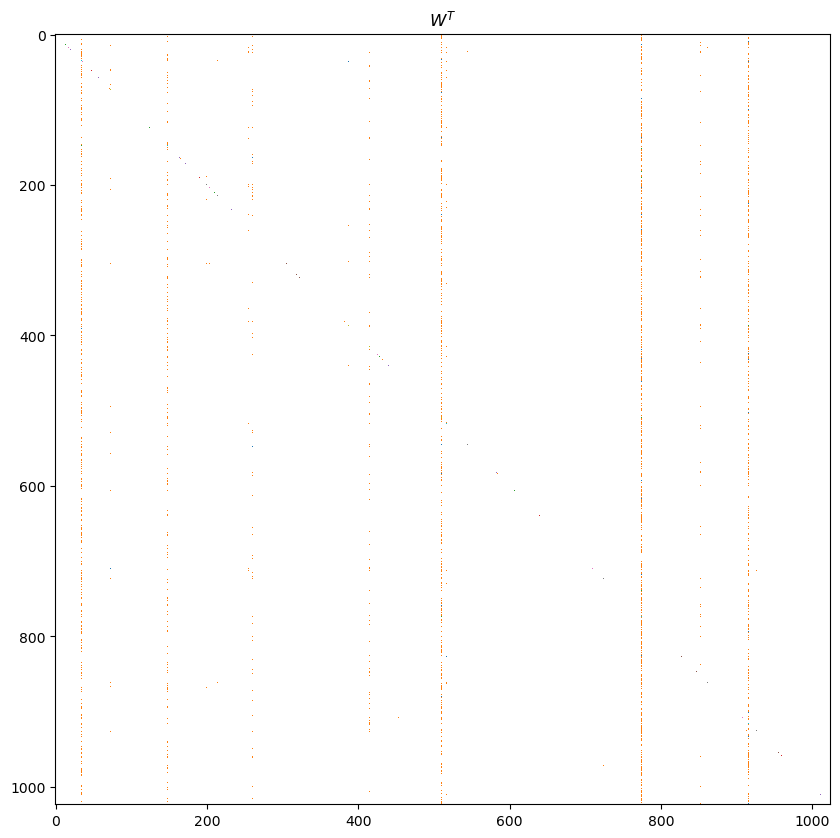

In [175]:
W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[matrix == 0.0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matrix.T, interpolation="nearest", aspect="auto", cmap="tab10")
ax.set_title("$W^{T}$")

Text(0.5, 1.0, '$W^{T}$')

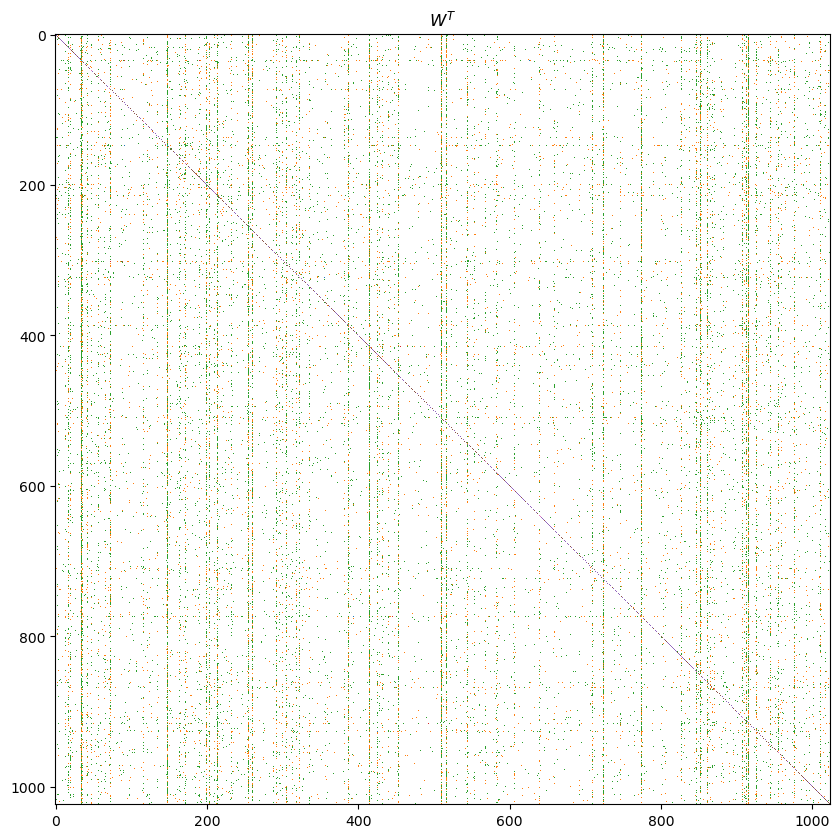

In [137]:
W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[matrix == 0.0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matrix.T, interpolation="nearest", aspect="auto", cmap="tab10")
ax.set_title("$W^{T}$")

In [176]:
print("Proportion zero: {:.2f}%".format(np.count_nonzero(W_numpy==0) / W_numpy.shape[0]**2 * 100))
print("Determinant:", linalg.det(W_numpy))

Proportion zero: 99.71%
Determinant: 0.0


## LinearVC on 256-dimensional WavLM